# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 


In [447]:
import pandas as pd
from netml.pparser.parser import PCAP
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

NF_DOMAINS = (["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"])

pcap = PCAP("../notebooks/data/netflix.pcap")
pcap.pcap2pandas()
ndf = pcap.df

nonpcapdf = pd.read_csv("../notebooks/data/netflix.csv.gz")
ndf['transaction_id'] = nonpcapdf['Info'].str.extract(r'(0x[0-9a-f]+)', expand=False)

ndf.head(10)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed,transaction_id
0,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,55697.0,UDP,1518358200.534682,0.000000,0xed0c
1,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,59884.0,UDP,1518358200.534832,0.000150,0x301a
2,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,61223.0,UDP,1518358200.539408,0.004726,0x11d3
3,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58785.0,UDP,1518358200.541204,0.006522,0x1284
4,2018-02-11 08:10:00,"(ytimg.l.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,51938.0,UDP,1518358200.545785,0.011103,0x3432
5,2018-02-11 08:10:00,"(r4---sn-gxo5uxg-jqbe.googlevideo.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,96,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,20949.0,UDP,1518358200.547036,0.012354,0xb756
6,2018-02-11 08:10:00,"(ssl.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58025.0,UDP,1518358200.547156,0.012474,0x62ab
7,2018-02-11 08:10:00,"(www.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,74,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,15895.0,UDP,1518358200.547249,0.012567,0x42fb
8,2018-02-11 08:10:00,"(pagead46.l.doubleclick.net.,)","(216.58.213.162,)",192.168.43.72,3.232247e+09,128.93.77.234,2.153598e+09,True,96,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,61223.0,53.0,UDP,1518358200.853950,0.319268,0x11d3
9,2018-02-11 08:10:00,"(www.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,18154.0,UDP,1518358200.853970,0.319288,0x8756


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [448]:
ddf = ndf[ndf['is_dns'] == True] 

# filter for Netflix ip addresses 
netflix_domains = '|'.join(NF_DOMAINS)
ntrs = ddf[ddf['dns_query'].astype(str).str.contains(netflix_domains, na=False)] 

# get the IP addresses for all the Netflix IPs
netflix_ips_tuples = ntrs['dns_resp'].dropna().unique()
netflix_ips = [ip[0] for ip in netflix_ips_tuples]

# filter for Netflix traffic
nflx = ndf[(ndf['ip_dst'].isin(netflix_ips)) | (ndf['ip_src'].isin(netflix_ips))]
nflx.head(10)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed,transaction_id
107,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58451.0,TCP,1518358202.903273,2.368591,NaN
109,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58452.0,TCP,1518358202.903319,2.368637,NaN
110,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58453.0,TCP,1518358202.903415,2.368733,NaN
112,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58454.0,TCP,1518358202.903625,2.368943,NaN
113,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58455.0,TCP,1518358202.903688,2.369006,NaN
114,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58456.0,TCP,1518358202.903769,2.369087,NaN
115,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58457.0,TCP,1518358202.903813,2.369131,NaN
116,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58458.0,TCP,1518358202.903940,2.369258,NaN
117,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58459.0,TCP,1518358202.903968,2.369286,NaN
119,2018-02-11 08:10:02,None,None,52.210.19.176,8.861828e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58460.0,TCP,1518358202.904207,2.369525,NaN


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [449]:
# select features that will be helpful for figuring out information about the quality of the video:
# packets per second, bytes per second, etc. 

# identify the flows for each packet
ndf['flow_id'] = ndf.groupby(['ip_src', 'ip_dst']).ngroup()
ndf_sorted = ndf.sort_values(['datetime', 'flow_id']).reset_index(drop=True)
ndf_sorted['time_diff'] = ndf_sorted.groupby('flow_id')['datetime'].diff().dt.total_seconds()
ndf_sorted['is_upstream'] = ndf_sorted['ip_dst'].isin(netflix_ips)

df_stats = ndf_sorted.groupby(['flow_id', 'ip_src', 'ip_dst']).agg({
    'is_upstream': ['all'],
    'length': ['sum', 'count'],
    'datetime': [lambda x: (x.max() - x.min()).total_seconds()], 
    'time_diff': ['mean'],
}).reset_index()

df_stats.columns = ['flow_id', 'ip_src', 'ip_dst', 'is_upstream', 'total_bytes', 'packet_count', 'duration', 'avg_time_diff']
df_stats = df_stats.sort_values('total_bytes', ascending=False)

df_stats['throughput_bps'] = df_stats['total_bytes']/df_stats['duration']
df_stats['throughput_pps'] = df_stats['packet_count']/df_stats['duration']

df_stats

,flow_id,ip_src,ip_dst,is_upstream,total_bytes,packet_count,duration,avg_time_diff,throughput_bps,throughput_pps
45,45.0,198.38.120.166,192.168.43.72,False,15995096,80084,476.0,0.005944,3.360314e+04,168.243697
24,24.0,192.168.43.72,198.38.120.166,True,3263517,47902,476.0,0.009937,6.856128e+03,100.634454
44,44.0,198.38.120.164,192.168.43.72,False,962237,4873,476.0,0.097701,2.021506e+03,10.237395
23,23.0,192.168.43.72,198.38.120.164,True,219916,3170,476.0,0.150205,4.620084e+02,6.659664
52,52.0,23.57.80.120,192.168.43.72,False,188346,1005,373.0,0.371514,5.049491e+02,2.694370
34,34.0,192.168.43.72,52.19.39.146,True,66768,489,431.0,0.883197,1.549142e+02,1.134571
54,54.0,52.19.39.146,192.168.43.72,False,64532,472,430.0,0.912951,1.500744e+02,1.097674
43,43.0,198.38.120.162,192.168.43.72,False,62110,338,75.0,0.222552,8.281333e+02,4.506667
32,32.0,192.168.43.72,23.57.80.120,False,59390,834,374.0,0.448980,1.587968e+02,2.229947
6,6.0,172.217.18.195,192.168.43.72,False,20126,144,495.0,3.461538,4.065859e+01,0.290909


**Write a brief justification for the features that you have chosen.**

I chose to analyze the data by flows to derive basic information about the different sources providing the data. Basic statistics like packet count, total bytes in the flow, and whether it was upstream or downstream (sending data to Netflix vs. Netflix sending data to the user) provide an initial understanding of the size and objective of the data. The duration of the flow is necessary for making rate calculations and for inferring what kind of activity the flow is performing. I also included the average time difference (iat) between packets sent in a flow, which is helpful for understanding segment rates. Bps and pps both provide a strong indicators of video quality -- bits per second measures bandwidth/network load, while packets per second measures capacity to process units that may vary in size. Having both is helpful for understanding where the balance is between packet size and quality. 

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [451]:
# number of video segments downloaded for a given time window
ndf_sorted['is_new_segment'] = ndf_sorted['time_diff'] > 1
ndf_sorted.loc[ndf_sorted['time_diff'].isna(), 'is_new_segment'] = 1

segment_counts = ndf_sorted.groupby('flow_id')['is_new_segment'].sum().rename('segment_count')
df_stats = df_stats.merge(segment_counts, on='flow_id') if 'segment_count' not in df_stats.columns else df_stats

df_stats['segment_download_rate'] = df_stats['segment_count'] / df_stats['duration'].replace(0, np.nan)

df_stats

/var/folders/g3/jvxqlblj49n7p12fpm8s8_fw0000gn/T/ipykernel_58017/575392778.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  ndf_sorted.loc[ndf_sorted['time_diff'].isna(), 'is_new_segment'] = 1


,flow_id,ip_src,ip_dst,is_upstream,total_bytes,packet_count,duration,avg_time_diff,throughput_bps,throughput_pps,segment_count,segment_download_rate
0,45.0,198.38.120.166,192.168.43.72,False,15995096,80084,476.0,0.005944,3.360314e+04,168.243697,60,0.12605
1,24.0,192.168.43.72,198.38.120.166,True,3263517,47902,476.0,0.009937,6.856128e+03,100.634454,57,0.119748
2,44.0,198.38.120.164,192.168.43.72,False,962237,4873,476.0,0.097701,2.021506e+03,10.237395,15,0.031513
3,23.0,192.168.43.72,198.38.120.164,True,219916,3170,476.0,0.150205,4.620084e+02,6.659664,12,0.02521
4,52.0,23.57.80.120,192.168.43.72,False,188346,1005,373.0,0.371514,5.049491e+02,2.694370,11,0.029491
5,34.0,192.168.43.72,52.19.39.146,True,66768,489,431.0,0.883197,1.549142e+02,1.134571,34,0.078886
6,54.0,52.19.39.146,192.168.43.72,False,64532,472,430.0,0.912951,1.500744e+02,1.097674,31,0.072093
7,43.0,198.38.120.162,192.168.43.72,False,62110,338,75.0,0.222552,8.281333e+02,4.506667,5,0.066667
8,32.0,192.168.43.72,23.57.80.120,False,59390,834,374.0,0.448980,1.587968e+02,2.229947,12,0.032086
9,6.0,172.217.18.195,192.168.43.72,False,20126,144,495.0,3.461538,4.065859e+01,0.290909,21,0.042424


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [453]:
pickle_file_path = 'netflix_dataset.pkl'
df = pd.read_pickle(pickle_file_path)

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [454]:
#  remove all resolutions that are not those ones
valid_resolutions = [240, 360, 480, 720, 1080]
df_clean = df[df['resolution'].isin(valid_resolutions)]
df = df_clean
df.shape

(49748, 251)

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [455]:
# set aside resolution info as labels for training
labels = df['resolution']
codes, unique_values = pd.factorize(df['session_id'])
df['session_id'] = codes

# remove columns that include information which cannot be inferred from a 
# pcap/include potential data leakage
removal_cols = ['bitrate', 'rebuffering', 'resolution', 'quality', 'video_id', 
                'video_duration', 'startup', 'deployment_session_id',
                'service', 'home_id','video_position', 'ads', '_75', 
                '_75R', '_85', '_85R', 'var', 'ske', 'kur', '10_EWMA_chunksizes', 
                'flags', 'cumsum_', 'all_prev', 'wireless']

# Get the list of columns to drop
regex_pattern = '(?i)' + '|'.join(removal_cols)
df_skinny = df.drop(columns=df.filter(regex=regex_pattern).columns)

zero_variance_cols = []
for col in df_skinny.columns:
  n_unique = df_skinny[col].nunique(dropna=False)

  if n_unique <= 1:
      zero_variance_cols.append(col)
      # Show what the constant value is
      unique_val = df_skinny[col].dropna().unique()

df_skinny = df_skinny.drop(columns=zero_variance_cols)

df_skinny.shape

(49748, 128)

**Briefly explain why you removed those columns.**

My initital intuition was to remove columns which would not be available in a 
packet capture. Information like bitrate, quality, video duration, etc. would 
likely be encrypted. If the model were trained on this information, it would 
not infer the resolutions in the testing set but instead use the information 
to give the right response, regardless of the other data. For our purposes, we 
ideally want the model to make these inferences with just a packet capture, so 
it makes sense to remove information that is impossible to infer from a pcap. 

I also removed columns which had 0 variance between each row, as they will not
prove useful for making inferences based on the variety of data in the set. 

Additionally, I removed a few statistics that are largely insignificant or 
redundant. Finally, I adhered to the standard practice of focusing on the 50th
percentile and the 90th percentile, rather than including the other ones as 
well. 

Reducing the size of the dataset in this way will hopefully improve the model's
performance and reduce the possibility of overfit.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [456]:
X = df_skinny
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [458]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [460]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import randint

param_grid = model.get_params()

params = {
  'n_estimators': randint(50, 500),
  'max_depth': randint(10, 50),
  'min_samples_split': randint(2, 50), 
  'min_samples_leaf': randint(1, 20) 
}

# using Randomized Search for the sake of time!
random_search = RandomizedSearchCV(model, params, n_iter=40, cv=2, random_state=42, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"best params: {random_search.best_params_}")
print(f"best CV score: {random_search.best_score_:.3f}")

# Use best model
best_model = random_search.best_estimator_
model = best_model

best params: {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 276}
best CV score: 0.918


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Accuracy: 0.9414070351758794

F1 Score: [0.67808219 0.85419059 0.96352509 0.930457   0.98218263]
[[ 198   30   80   18    0]
 [  31  744  141    9    0]
 [  22   33 5904   25    1]
 [   7   10  145 1639   19]
 [   0    0    0   12  882]]

Confusion Matrix:


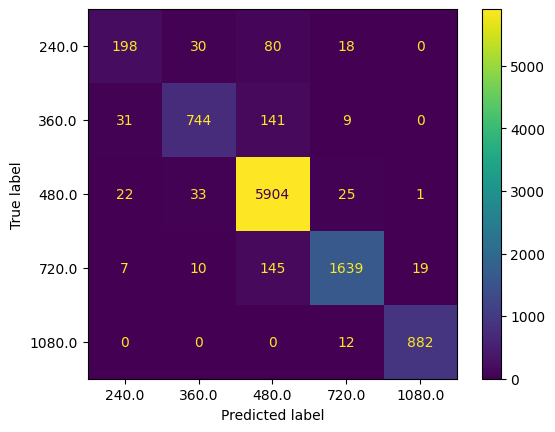

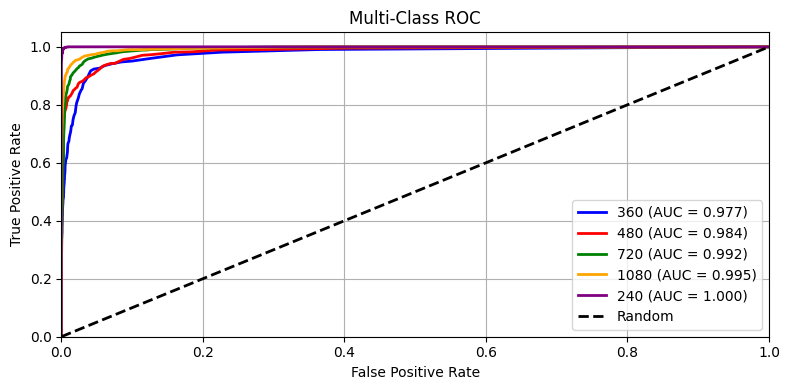

In [461]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

# F1 score
f1 = f1_score(y_test, y_pred, average=None)
print("\nF1 Score: {}".format(f1))

# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.savefig('pipeline_confusion-matrix.png')
print("\nConfusion Matrix:")
plt.show()

# ROC/AUC: Helped by Chase's example in the Slack
y_val_bin = label_binarize(y_test, classes=[240., 360., 480., 720., 1080.])
        
class_names = ['360', '480', '720', '1080', '240']
colors = ['blue', 'red', 'green', 'orange', 'purple']
        
plt.figure(figsize=(8, 4))
        
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
            label=f'{class_name} (AUC = {roc_auc:.3f})')
        
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Multi-Class ROC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

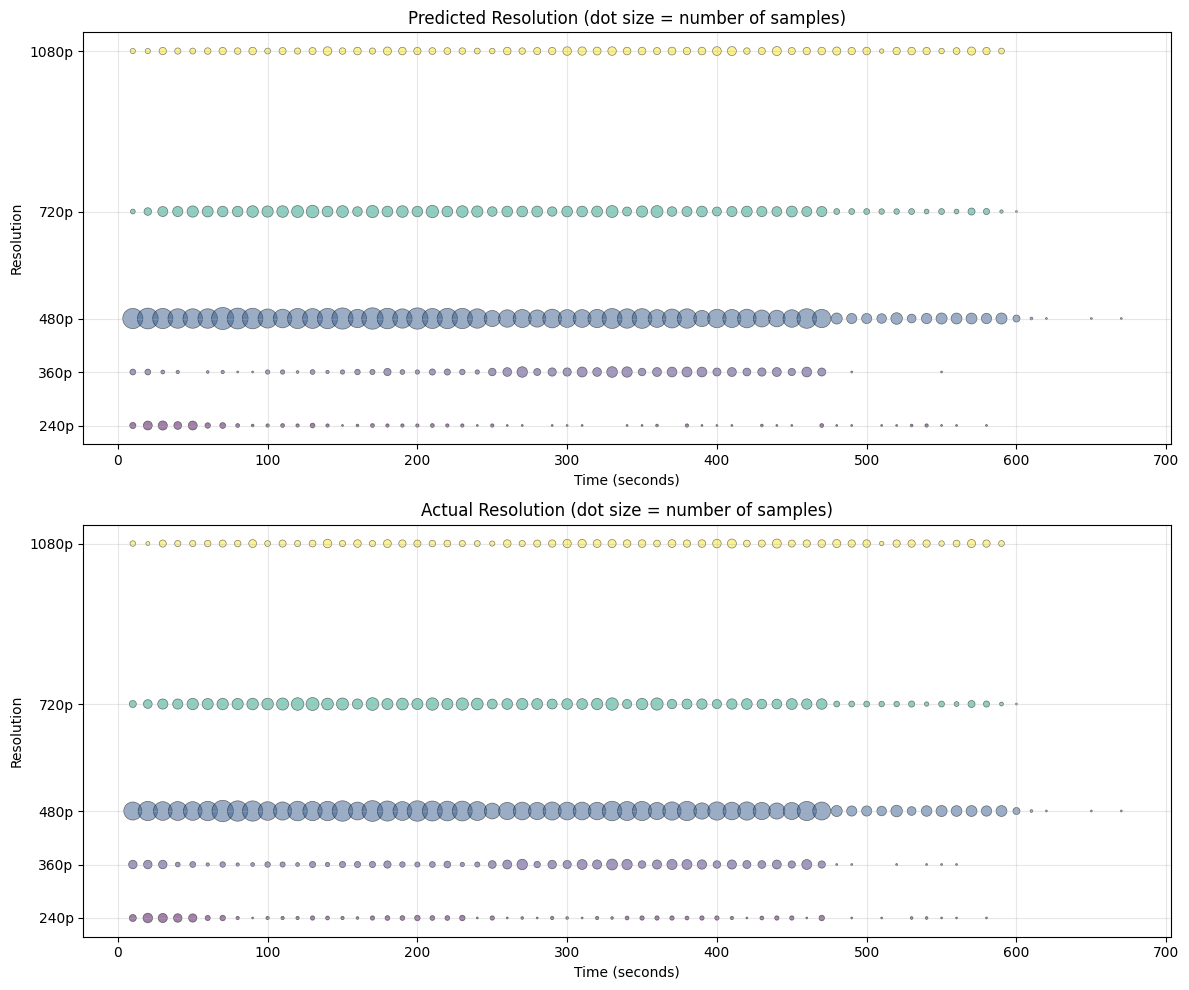

In [462]:
# make predictions on the data we set aside
y_val_pred = model.predict(X_val)
timestamps = X_val['relative_timestamp']

df_vis = pd.DataFrame({
    'timestamp': X_val['relative_timestamp'],
    'actual': y_val,
    'predicted': y_val_pred
})

# get the actual counts and predicted counts for two different subplots to see both
actual_counts = df_vis.groupby(['timestamp', 'actual']).size().reset_index(name='count')
predicted_counts = df_vis.groupby(['timestamp', 'predicted']).size().reset_index(name='count')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

ticks = [240, 360, 480, 720, 1080]
tick_labels = ['240p', '360p', '480p', '720p', '1080p']

# predicted resolutions
scatter1 = axes[0].scatter(predicted_counts['timestamp'], predicted_counts['predicted'],
                          s=predicted_counts['count']*2, alpha=0.5, 
                          c=predicted_counts['predicted'], edgecolors='black', 
                          linewidth=0.5)

axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Resolution')
axes[0].set_title('Predicted Resolution (dot size = number of samples)')
axes[0].set_yticks(ticks)
axes[0].set_yticklabels(tick_labels)
axes[0].grid(True, alpha=0.3)

# actual resolutions
scatter1 = axes[1].scatter(actual_counts['timestamp'], actual_counts['actual'],
                          s=actual_counts['count']*2, alpha=0.5, 
                          c=actual_counts['actual'], edgecolors='black', 
                          linewidth=0.5)

axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Resolution')
axes[1].set_title('Actual Resolution (dot size = number of samples)')
axes[1].set_yticks(ticks)
axes[1].set_yticklabels(tick_labels)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# NOTE: I used Claude to learn how to create a graph where the points 
# were different sizes based on how many data points were aggregated at that 
# timestamp and resolution. The idea and logic is my own.